In [1]:
import pandas as pd
# from tashaphyne.stemming import ArabicLightStemmer
import seaborn as sns
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Conv1D , GlobalMaxPooling1D , Reshape , Embedding, LSTM, Dense,Bidirectional,Dropout
from deep_translator import GoogleTranslator
from deep_translator.exceptions import RequestError
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from nltk.stem.isri import ISRIStemmer
from sklearn.metrics import f1_score, accuracy_score
import nlpaug.augmenter.word as naw
from sklearn.model_selection import train_test_split

# Telechargement des donnees

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,ID,comment,label
0,1,انا اوصي من هذا المنبر الكل للتوجه الى مراكز ا...,1
1,2,\nهناك الكثير لا يفهم المقصود كورونا ليست صعبة...,1
2,3,الحمد لله ارقام مقبولة مقارنة بدول المنطقة لول...,1
3,4,انا شخصيا أؤيد ما فرضته السلطات من ضرورة الإدل...,1
4,5,\nنفس الشئ في مدينة برشيد مراكز التلقيح مغلقة ...,1


In [4]:
chemin_fichier = "stop_words_arabic.txt"

StopWords = []

with open(chemin_fichier, 'r',encoding='utf-8') as fichier:
    StopWords = fichier.readlines()
StopWords = [mot.strip() for mot in StopWords]
StopWords

['فى',
 'في',
 'كل',
 'لم',
 'لن',
 'له',
 'من',
 'هو',
 'هي',
 'قوة',
 'كما',
 'لها',
 'منذ',
 'وقد',
 'ولا',
 'نفسه',
 'لقاء',
 'مقابل',
 'هناك',
 'وقال',
 'وكان',
 'نهاية',
 'وقالت',
 'وكانت',
 'للامم',
 'فيه',
 'كلم',
 'لكن',
 'وفي',
 'وقف',
 'ولم',
 'ومن',
 'وهو',
 'وهي',
 'يوم',
 'فيها',
 'منها',
 'مليار',
 'لوكالة',
 'يكون',
 'يمكن',
 'مليون',
 'حيث',
 'اكد',
 'الا',
 'اما',
 'امس',
 'السابق',
 'التى',
 'التي',
 'اكثر',
 'ايار',
 'ايضا',
 'ثلاثة',
 'الذاتي',
 'الاخيرة',
 'الثاني',
 'الثانية',
 'الذى',
 'الذي',
 'الان',
 'امام',
 'ايام',
 'خلال',
 'حوالى',
 'الذين',
 'الاول',
 'الاولى',
 'بين',
 'ذلك',
 'دون',
 'حول',
 'حين',
 'الف',
 'الى',
 'انه',
 'اول',
 'ضمن',
 'انها',
 'جميع',
 'الماضي',
 'الوقت',
 'المقبل',
 'اليوم',
 'ـ',
 'ف',
 'و',
 'و6',
 'قد',
 'لا',
 'ما',
 'مع',
 'مساء',
 'هذا',
 'واحد',
 'واضاف',
 'واضافت',
 'فان',
 'قبل',
 'قال',
 'كان',
 'لدى',
 'نحو',
 'هذه',
 'وان',
 'واكد',
 'كانت',
 'واوضح',
 'مايو',
 'ب',
 'ا',
 'أ',
 '،',
 'عشر',
 'عدد',
 'عدة',
 'عشرة',
 '

# 

# Pretraitment des donnees

In [5]:
data.isna().sum()

ID         0
comment    0
label      0
dtype: int64

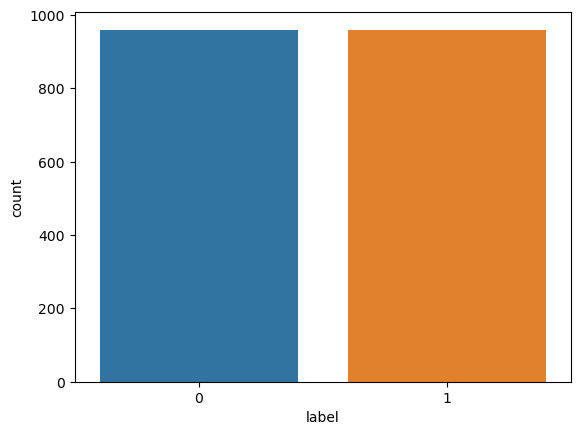

In [6]:
sb = sns.countplot(data,x='label')

In [7]:
data["comment"][0]

'انا اوصي من هذا المنبر الكل للتوجه الى مراكز التلقيح صدقوني الامر ليس مزحة او مرض الزكام هو بالفعل مرض قاتل انا ايضا كنت من الذين لا يريدون اللقاح لكن عندما اصيب زوج اختى وشاهدت حالته التي وصلت الى الموت لولا لكف الله به لكان الان من المرحومين وعمره في الثلاثينلا تصدقوا الشائعات حول المرض وانه غير قاتل ويصيب فقط العواجيز هذا كله كذب بل يصيبىاي احد ويقتل حتى اشد الناس قوةاتمنى من بعض المغاربة ان يقدموا مصلحة المجتمع على انانيتهم الخاصة وكفى نشر ترهات وسخافات '

In [8]:


def supprimerCaracteresSpeciaux(df, colonne, caracteres_a_supprimer, remplacement):
    df_copy = df.copy()
    for i in range(len(df_copy[colonne])):
        texte_original = df_copy.at[i, colonne]
        texte_modifie = ""
        for lettre in texte_original:
            if lettre not in caracteres_a_supprimer:
                texte_modifie += lettre
            else:
                texte_modifie += remplacement
        df_copy.at[i, colonne] = texte_modifie
    return df_copy   
        
        
def supprimerStopWord(df, colonne, stopwords_df):
    stopwords_list = StopWords

    for i in range(len(df[colonne])):
        mots = df[colonne][i].split(' ')
        paragraph = " ".join(mot for mot in mots if mot.lower() not in stopwords_list)
        df.loc[i, colonne] = paragraph



def stemming(text):
    st = ISRIStemmer()
    stemmed_words = []
    word_tokens = word_tokenize(text) 
    for w in word_tokens:
        stemmed_words.append(st.stem(w))
    stemmed_words = " ".join(stemmed_words)
    return stemmed_words


def remove_english_characters(text):
        return re.sub(r'[a-zA-Z]+', '', text)

def NormalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return text


In [9]:
caracteres_a_supprimer = ['0','1','2','3','4','5','6','7','8','9','💕💉','#','!', '@', '$', '%', '^', '*', '\n', '\t', '\s', '(', ')', '_', '\-', '+', '=', '|', '?', '>', '.', ',', '[', ']', '{', '}', '`', '~', '\\', '/','؛']
dt=supprimerCaracteresSpeciaux(data, 'comment',caracteres_a_supprimer," ")
supprimerStopWord(dt, 'comment', StopWords)
dt

,ID,comment,label
0,1,انا اوصي المنبر الكل للتوجه مراكز التلقيح صدقو...,1
1,2,الكثير يفهم المقصود كورونا ليست صعبة الشباب ل...,1
2,3,الحمد لله ارقام مقبولة مقارنة بدول المنطقة لول...,1
3,4,انا شخصيا أؤيد فرضته السلطات ضرورة الإدلاء بجو...,1
4,5,نفس الشئ مدينة برشيد مراكز التلقيح مغلقة إلى ...,1
...,...,...,...
1915,1916,والله دمرونا وتعداو علينا شي ميقراش شي ميخدمش...,0
1916,1917,لقاح موت سم فيقو عباد الله,0
1917,1918,اللقاح آمن، تجاهل عشرات شهادات الأطباء العالم،...,0
1918,1919,لنكن واقعيين…لا يجب فرظ التلقيح بالقوة انا تل...,0


In [10]:
# # SupprimNombre(dt, 'comment')
# dt = dt.dropna()
# dt

In [11]:
for index, row in dt.iterrows():
    row['comment'] = remove_english_characters(row['comment'])
#     row['comment'] = NormalizeArabic(row['comment'])
#     row['comment'] = stemming(row['comment'])

    new_df = pd.DataFrame({'comment': [row['comment']]}, index=[index])
    dt.update(new_df)
dt

,ID,comment,label
0,1,انا اوصي المنبر الكل للتوجه مراكز التلقيح صدقو...,1
1,2,الكثير يفهم المقصود كورونا ليست صعبة الشباب ل...,1
2,3,الحمد لله ارقام مقبولة مقارنة بدول المنطقة لول...,1
3,4,انا شخصيا أؤيد فرضته السلطات ضرورة الإدلاء بجو...,1
4,5,نفس الشئ مدينة برشيد مراكز التلقيح مغلقة إلى ...,1
...,...,...,...
1915,1916,والله دمرونا وتعداو علينا شي ميقراش شي ميخدمش...,0
1916,1917,لقاح موت سم فيقو عباد الله,0
1917,1918,اللقاح آمن، تجاهل عشرات شهادات الأطباء العالم،...,0
1918,1919,لنكن واقعيين…لا يجب فرظ التلقيح بالقوة انا تل...,0


In [12]:
dt["comment"][1919]

'  التنسيقية الوطنية للمغاربة الرافضين للتلقيح الإجباري ستنزل للشارع '

# 

# Data Augmentation

In [13]:
# Récupération des phrases et labels depuis data
phrases = dt['comment'].tolist()
labels = dt['label'].tolist()

# Initialisation de l'augmenteur de synonymes
aug = naw.SynonymAug(aug_src='wordnet')

# Augmentation des phrases
augmented_phrases = [aug.augment(phrase) for phrase in phrases]

# Création de la liste complète de phrases et de labels
all_phrases = phrases + augmented_phrases
all_labels = labels + labels  

# Mélange aléatoire des données
shuffled_indices = np.random.permutation(len(all_phrases))

# Création du dataframe pandas avec les données mélangées
df = pd.DataFrame({
    'comment': [all_phrases[i] for i in shuffled_indices],
    'label': [all_labels[i] for i in shuffled_indices]
})

caracteres_a_supprimer = ['0','1','2','3','4','5','6','7','8','9','💕💉','#','!','?', '@', '$', '%', '^', '*', '\n', '\t', '\s', '(', ')', '_', '\-', '+', '=', '|', '?', '>', '.', ',', '[', ']', '{', '}', '`', '~', '\\', '/']
df=supprimerCaracteresSpeciaux(df, 'comment',caracteres_a_supprimer," ")
df


,comment,label
0,انت حر جسدك ،ومن حقك تمتنع حقنه بمواد يعلمها ...,0
1,اللقاح ضروري انتها الموضوع,1
2,التحاد الاروبي الوليات المتحدة سيبنون معمل ال...,0
3,تضرر وذهب إليهم يقولون السبب منك وليس اللقاح,0
4,رأيي المناعة الجماعية الحل تمويل الميدان الصح...,0
...,...,...
3835,الحل بسيط : اللقاح,1
3836,هل الخبر صحيح وإن نسبة كبيرة المغاربة وخصوصا ك...,0
3837,هاذ حقوق الانسان المغرب بزناسة ديال بصح تبتز ا...,1
3838,فلا يعقل شخص أشخاص يشككون التلقيح ويلعبون دور ...,1


In [14]:
print(all_phrases[1])

 الكثير يفهم المقصود كورونا ليست صعبة الشباب لكنها صعبة اصحاب مرض مزمن كالسكري …  لهذا الدولة اختارت تنقد امهاتنا ابائنا مرضى السكري قام سيعم الجميع الحقيقة يتم التلقيح يتم محاصرة الفيروس بالتلقيح ينتهي المشكل أن يعم الفيروس الشرائح لهذا نتمنى تسرع الدولة مخططها لما تأثير محاربة الوباء اقرب وقت ممكن نتمنى الله  التوفيق لكل يساهم بعيد قريب انجاح المهمة الشكر كذلك لصاحب الجلالة يبخل لمثل المبادرة ستعود بالصحة العافية تحية للشعب المغربي طنجة إلى الݣرݣرات 


In [15]:
df['comment'][1919]

'اصحاب التعليقات السلبية إن افترضنا جدلا أن إنتاج لقاح كورونا مفيد الراهن تدعون أنها فرقعات فالرهان أكبر بكتير: المغرب يراهن اكتساب خبرة تقنية صنع لقاحات البحت العلمي المتخصص الميدان التوفر موارد بشرية مؤهلة لذلك الأهداف المتوخاة الخطوات أما البيع الشراء فلن يربح منه المغرب الشيء الكتير لأن مساهمته السلسلة القيمية ضعيفة مقارنة بنسبة توطين الكنتوج نهار يوقف المغرب رجليه تولي عندو “ صنع بالمغرب ” ليسونس مغربية داك ساعات يتجرأ مخبول منكم هكذا تعليقات واللي مابغاتش تفهم ليه هده المسألة يمشي لكزناية قنيطرة باش يشوف الصناعات المعقدة للسيارات فين وصلات الكفاءات المغربية تطورت ملحوظ وطلو علا جيرانكم بقاو يصوبو البنوات بالرغم الثمن سوف نؤديه لذلك إلا أننا متيقنون بلوغ الأهداف التنموية تليق بمكانة المغرب كواجهة إفريقية بامتياز'

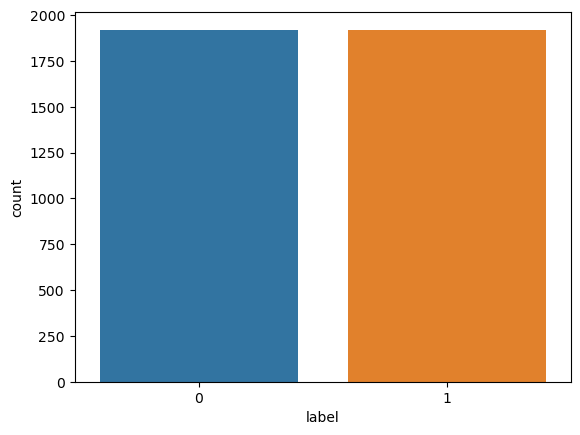

In [16]:
sb = sns.countplot(df,x='label')

In [17]:
X=df['comment']
Y=df['label']
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
x_test

746     اللقاح اخذاوه وماتو وخذاوه وتشلو ودابا اش خاصك...
3837    هاذ حقوق الانسان المغرب بزناسة ديال بصح تبتز ا...
3218     لمن يقول المغرب كوريا الشمالية فهو خاطئ  كوري...
2778    معادلة متناقضة … في ياتي المواطنون للتلقيح نجد...
1904    بفضل السهر والتتبع لجلالة الملك صحة وأمن المغا...
                              ...                        
1018                     أحسن تلقيح جونسون، تجربتي الخاصة
449     عندكم فهم غلط اللقاح اللقاح راه كايمنع الفيروس...
1288                        يجب منع الجماهير جواز التلقيح
376     اللقاح يبقى ليس  إجباري  لان كتير ناس تعاني أم...
1592    كفى استحمار الناس القول أنها آمنة هل قامت وزار...
Name: comment, Length: 768, dtype: object

# 

# Tokenisation des donnees

In [18]:

vocab_size = 90000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [19]:

# Parameters
embedding_dim = 32
lstm_dim = 128
dense_dim = 24



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [20]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           2880000   
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 64)                245824    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3132097 (11.95 MB)
Trainable params: 3132

In [21]:
N = 10
# l'entrainement du medel
history= model.fit(training_padded, training_labels, epochs = N, validation_data=(testing_padded, testing_labels))

Epoch 1/10


96/96 [==============================] - 4s 30ms/step - loss: 0.8186 - accuracy: 0.6077 - val_loss: 0.5802 - val_accuracy: 0.7331
Epoch 2/10
96/96 [==============================] - 3s 28ms/step - loss: 0.2966 - accuracy: 0.9297 - val_loss: 0.2112 - val_accuracy: 0.9453
Epoch 3/10
96/96 [==============================] - 2s 26ms/step - loss: 0.0632 - accuracy: 0.9951 - val_loss: 0.1430 - val_accuracy: 0.9466
Epoch 4/10
96/96 [==============================] - 3s 29ms/step - loss: 0.0317 - accuracy: 0.9987 - val_loss: 0.1926 - val_accuracy: 0.9323
Epoch 5/10
96/96 [==============================] - 3s 28ms/step - loss: 0.0246 - accuracy: 0.9980 - val_loss: 0.1219 - val_accuracy: 0.9583
Epoch 6/10
96/96 [==============================] - 3s 27ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.1180 - val_accuracy: 0.9505
Epoch 7/10
96/96 [==============================] - 3s 27ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.1164 - val_accuracy: 0.9505
Epoch 8/10


In [22]:
y_pred = model.predict(testing_padded)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(testing_labels, y_pred_binary)
f1 = f1_score(testing_labels, y_pred_binary)

print("Accuracy : {:.2f}%".format(accuracy * 100))
print("F1 Score : {:.2f}%".format(f1*100))

24/24 [==============================] - 0s 2ms/step
Accuracy : 94.01%
F1 Score : 94.25%


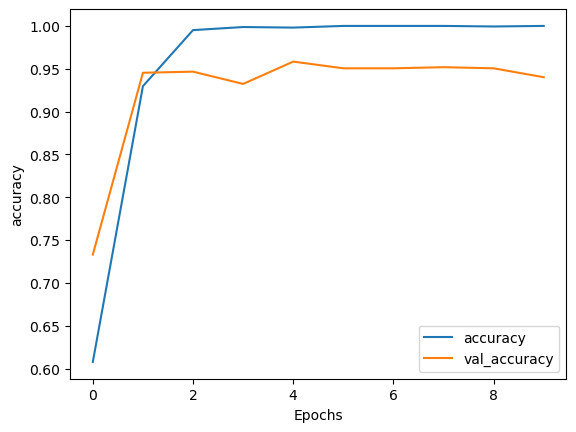

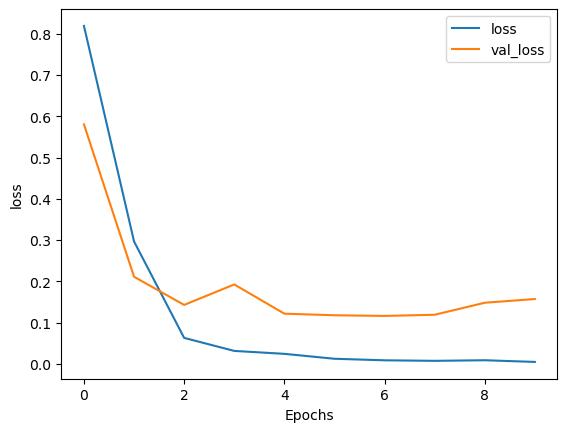

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [25]:
# n=1
new_text =dt["comment"][1]
print('Le reel class est :', dt['label'][1])


new_text_sequence = tokenizer.texts_to_sequences([new_text])
padded_sequence = pad_sequences(new_text_sequence, maxlen=max_length, padding='post')

# Prédiction
prediction = model.predict(padded_sequence)

# Affichage de la prédiction
print("La classe predite est :", np.round(prediction[0][0]))

Le reel class est : 1
1/1 [==============================] - 0s 87ms/step
La classe predite est : 1.0
